In [1]:
import uavgeo as ug
import geopandas as gpd
import rioxarray as rxr
import numpy as np
import ultralytics
import xarray as xr
import matplotlib.pyplot as plt
import cv2

c:\users\judoj\documents\programming\uavgeo\uavgeo\compute\products.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Geographic DATASET TRAIN/VAL/TEST Splitting
For pix2pix we want a style a and style b dataset: so we create an RGB and NDVI dataset. splitted on chips in the larger orthomosaic.

This requires 3 steps:
1. Loading data
2. Defining the splits in space
3. chipping the dataset and saving the imgs to disk

## 1. Loading datasets
Load the orthomosaic
and some other geopgrahic data, in which the quality is 100% sure: the three rows of the vineyard that are covered by the flight path.



In [2]:
rgb = rxr.open_rasterio("../data/orthos/rgb_2022.tif")
#sq_nir = rxr.open_rasterio("data/scenariob_barley_potato/nir_sequioa_wageningen_testfield.tif")
#sq_red = rxr.open_rasterio("data/scenariob_barley_potato/red_sequioa_wageningen_testfield.tif")
ms = rxr.open_rasterio("../data/orthos/ms_2021.tif")



In [3]:
def scale_band_to_min_max(band, min,max, clip =True):

    if clip:
        band = band.clip(min = min, max=max)
        
    band = band.astype(float)
    band = (band-min) * (255/(max-min))
    return band.astype(np.uint8)

In [4]:
# align NDVI to RGB:
rgb_matched = rgb.rio.reproject_match(ms).sel(band=[1,2,3])

In [5]:
# calculate NDVI values
ndvi = ug.compute.calc_ndvi(ms, red_id =4, nir_id=6, rescale= True)

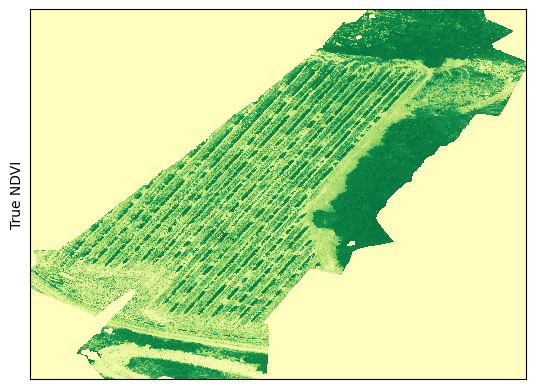

In [9]:
fig, ax = plt.subplots()
ndvi.plot(ax=ax, cmap ="RdYlGn", add_colorbar=False,vmin =0, vmax=255)
ax.set_title("")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("True NDVI")
#ax.set_ylim(ylims)
#ax.set_xlim(xlims)

plt.show()

### Train / val / test splits

The train and val splits are with input_overlap at 128, whilst test is without: so the dataset is passed through the following bit twice. See 6_scenarioA how these are made with overlaps etc.


In [9]:
# The image is a bit big: perhaps we can look at a small chip of the dataset for a better look:

# size of chips to be made 
input_dims = {"x": 256, "y":256}
input_overlap = {"x": 0, "y":0} # change this to 0 for the test-set

#shape (resolution) of input image
shape = rgb_matched.shape
c = rgb_matched.rio.crs
chips = ug.compute.create_chip_bounds_gdf(input_dims = input_dims, input_overlap=input_overlap, shape_x = shape[2], shape_y = shape[1], crs = c)
chips["crs_geom"] = chips["geometry"].apply(lambda x: ug.compute.imgref_to_crs(rgb_matched, x)) 
chips = chips.set_geometry(chips["crs_geom"])

In [10]:
# need to clip to the best possible dataset-section: which is in the bounds of the trunks + 3meter
expand = 3
offset = 0
trunks = gpd.read_file("../data/trunks.geojson").to_crs(rgb.rio.crs)

minx = trunks.geometry.x.min()
miny = trunks.geometry.y.min()
maxx = trunks.geometry.x.max()
maxy = trunks.geometry.y.max()

y = trunks.geometry.y[trunks.geometry.x==minx]
bl = (minx-expand-offset,y-expand) 

x = trunks.geometry.x[trunks.geometry.y==maxy]
tl = (x-expand-offset, maxy+expand)

y = trunks.geometry.y[trunks.geometry.x==maxx]
tr = (maxx+expand-offset, y+expand)

x = trunks.geometry.x[trunks.geometry.y==miny]
br = (x+expand-offset,miny-expand )


from shapely import Polygon

p = Polygon([bl,tl, tr,br])

C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\shapely\geometry\polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


In [11]:
# find all chips that are within the intersection between the trunks-geom and themselves
chippies = chips.set_geometry(chips["crs_geom"])
trunk_outline = gpd.GeoSeries(p,crs = rgb.rio.crs)
chippies["intersects"] = chippies["geometry"].apply(lambda x: trunk_outline.intersects(x))
chippies = chippies[chippies["intersects"]].copy()
print(len(chippies))

129


In [12]:
chippies.drop(columns = ["crs_geom"]).to_file("../data/chips2022v2.geojson")

In [13]:
chippies = gpd.read_file("../data/chips2022v2.geojson")

## 2. Visualizing

Let's visualize what we actually did.

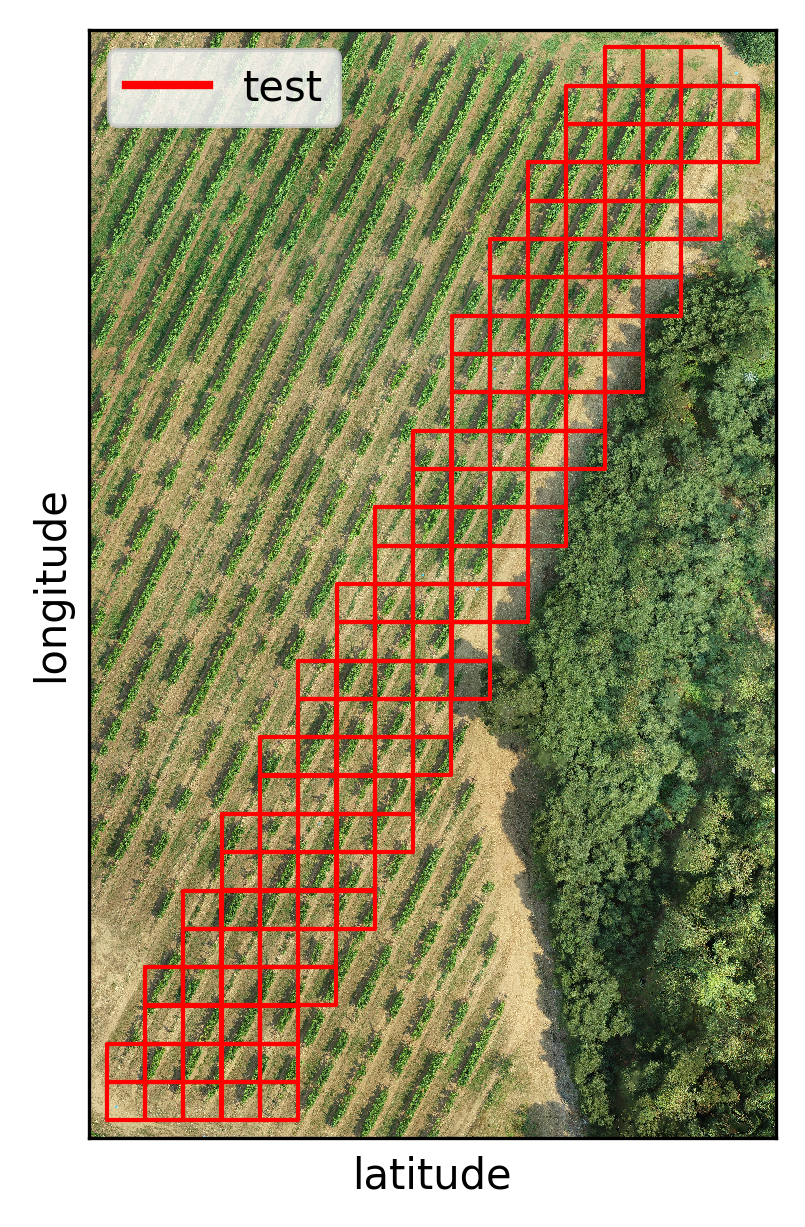

In [23]:
fig, ax = plt.subplots(dpi = 300)

rgb.plot.imshow(ax=ax)
ax.set_title("")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("latitude")
ax.set_ylabel("longitude")

chippies.plot(ax=ax, facecolor= "none", edgecolor= 'red' ,label="test")
#val.plot(ax=ax, facecolor= "none", edgecolor= 'green', label= "val" )
#test.plot(ax=ax, facecolor= "none", edgecolor= 'red', label = "test" )
# we know that 
ax.set_ylim((chippies.geometry.bounds.min().miny-2,chippies.geometry.bounds.max().maxy+2))

ax.set_xlim(((chippies.geometry.bounds.min().minx-2,chippies.geometry.bounds.max().maxx+2)))

# Create custom legend labels and colors using patches
legend_elements = [
    plt.Line2D([0], [0], color='red', lw=2, label='test'),
]

plt.legend(handles=legend_elements, loc= "upper left")

plt.savefig("figures/BTG2022_test_chips.png", dpi =300)
plt.show()

## 3. Actual subsetting of the imagery 
Requires the orthomosaic, coloured to nice colours and called 'da', see above.

#### Starting with the RGB: style A

In [15]:
#clip RGB set:

rgbs = [rgb_matched.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3]) for i, row in chippies.iterrows()]


In [16]:
# transpose to RGB instead of BANDS
rgbs = [np.transpose(img.values, (1,2,0)) for img in rgbs]



In [16]:
rgbs[0].shape

(256, 256, 3)

#### repeat for NDVI: Style B

In [17]:
#clip NDVI set

ndvis = [ndvi.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3]) for i, row in chippies.iterrows()]
#ndvis = [scale_band_to_min_max(nd, min = -1, max=1) for nd in ndvis]

In [18]:
# transpose to ndvi img
ndvis = [np.reshape(img.values, (256,256)) for img in ndvis]


In [19]:
import os
from PIL import Image

def export_image_list(path, img_list, subset):

    for i in range(len(img_list)):
        filename =subset + f"{i:0>{6}}" +".jpg"
        filepath = os.path.join(path, filename)
        im = Image.fromarray(img_list[i])
        im.save(filepath)

In [22]:
#Its Saving TIME
import os
# FORMAT IS EXPECTED:
path = os.path.join("../data")

#for style A: aka RGB

#export:
test_path = os.path.join(path, "trgb_2022_chips_v2")
export_image_list(test_path, rgbs, "vineyard")

test_path = os.path.join(path, "ndvi_2022_chips_v2")
export_image_list(test_path, ndvis, "vineyard")

In [22]:
len(ndvis)

179